In [106]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression

%matplotlib inline
%load_ext nb_black

plt.rcParams["figure.figsize"] = (14, 7)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [107]:
comps = pd.read_csv("../data/Comps.csv")
seasonality = pd.read_csv("../data/Seasonality.csv")

<IPython.core.display.Javascript object>

In [108]:
comps.head()

,url,beds,bath,rabbu Occupancy,rabbu ADR,manual Occupancy,manual ADR,Notes,Location,Stars,Review,Cleaning Fee,Host
0,https://www.airbnb.com/rooms/46038476,2,2,0.53,143,0.903226,134.0,NaN,North Bend,4.98,41,80.0,Superhost
1,https://www.airbnb.com/rooms/54064539,2,2,0.83,251,0.645161,245.0,"Too fancy, comp won’t compare",North Bend,4.99,75,95.0,Superhost
2,https://www.airbnb.com/rooms/52210633,2,1,0.70,189,0.645161,189.0,"No Dynamic Pricing, looks like a house, not a ...",North Bend,4.96,45,95.0,Superhost
3,https://www.airbnb.com/rooms/721062423659714038,2,2,0.73,387,0.580645,350.0,"Fancy, Cabin Style",North Bend,4.89,19,125.0,Superhost
4,https://www.airbnb.com/rooms/566008910384238034,2,1,0.67,283,0.451613,281.0,"Bad Photos, On River",North Bend,4.89,64,80.0,Superhost


<IPython.core.display.Javascript object>

In [109]:
quants = np.quantile(comps.Stars[comps.Review > 10], q=[0.2, 0.4, 0.6, 0.8])

<IPython.core.display.Javascript object>

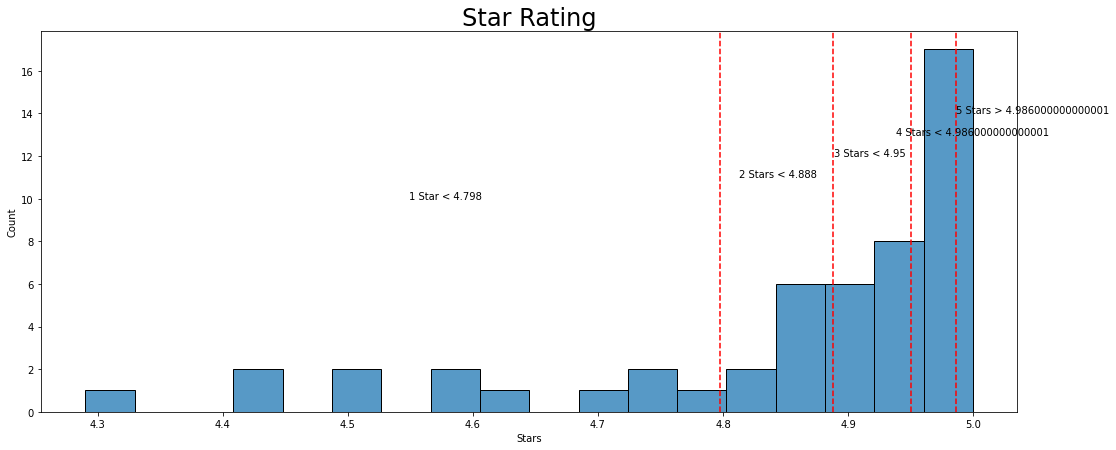

<IPython.core.display.Javascript object>

In [110]:
plt.rcParams["figure.figsize"] = (17.5, 7)
star_histogram = sns.histplot(comps.Stars, bins=18)
ax = plt.gca()
for quant in quants:
    ax.axvline(
        x=quant, ymin=0, ymax=16, color="red", linestyle="dashed"
    )  # Line on x = 2  # Bottom of the plot
# sns.vline(quants)
star_histogram.set_title("Star Rating", fontsize=24)
ax.text((quants[0] + 4.3) / 2, 10, s=f"1 Star < {quants[0]}")
ax.text((quants[1] + quants[0]) / 2 - 0.03, 11, s=f"2 Stars < {quants[1]}")
ax.text((quants[2] + quants[1]) / 2 - 0.03, 12, s=f"3 Stars < {quants[2]}")
ax.text((quants[3] + quants[2]) / 2 - 0.03, 13, s=f"4 Stars < {quants[3]}")
_ = ax.text(quants[3], 14, s=f"5 Stars > {quants[3]}")

In [111]:
fig = px.scatter(
    comps,
    y="manual Occupancy",
    x="manual ADR",
    color="Host",
    hover_data=["Notes", "url"],
)
fig.show()

# adr_vs_ocp = sns.scatterplot(
#     data=comps, x="manual Occupancy", y="manual ADR", hue="Host"
# )

<IPython.core.display.Javascript object>

In [112]:
exclude_indx = [11, 5, 48]
comps.drop(index=exclude_indx, inplace=True)

<IPython.core.display.Javascript object>

In [113]:
fig = px.scatter(
    comps,
    y="manual Occupancy",
    x="manual ADR",
    color="Host",
    hover_data=["Notes", "url"],
)
fig.add_shape(
    type="line",
    x0=0,
    y0=0.752611,
    x1=500,
    y1=0.752611 + 500 * -0.0009,
)
fig.show()

<IPython.core.display.Javascript object>

In [18]:
comps.groupby(["Host"])["Stars"].count()

Host
Corporate    11
Regular       9
Superhost    28
Name: Stars, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
mod_data = comps[["manual ADR", "manual Occupancy", "Host"]].copy()
mod_data = mod_data[mod_data["manual ADR"] <= 500]
mod_data = pd.get_dummies(data=mod_data, prefix="host", columns=["Host"])
mod_data.drop(columns=["host_Regular"], inplace=True)
mod_data.head()

,manual ADR,manual Occupancy,host_Corporate,host_Superhost
0,134.0,0.903226,0,1
1,245.0,0.645161,0,1
2,189.0,0.645161,0,1
3,350.0,0.580645,0,1
4,281.0,0.451613,0,1


<IPython.core.display.Javascript object>

In [44]:
X = mod_data[["manual ADR"]]  # , "host_Corporate", "host_Superhost"]]
X = sm.add_constant(X)
y = mod_data[["manual Occupancy"]]
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       manual Occupancy   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     5.538
Date:                Wed, 12 Jul 2023   Prob (F-statistic):             0.0230
Time:                        21:52:57   Log-Likelihood:                 9.8586
No. Observations:                  47   AIC:                            -15.72
Df Residuals:                      45   BIC:                            -12.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7526      0.095      7.925      0.000       0.561       0.944
manual ADR    -0.0009      0.000     -2.353      0.023      -0.002      -0.000
==============================================================================
Omnibus:                        1.804   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.202
Skew:                          -0.066   Prob(JB):                        0.548
Kurtosis:                       2.228   Cond. No.                         802.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [47]:
res.params

const         0.752611
manual ADR   -0.000905
dtype: float64

<IPython.core.display.Javascript object>

In [50]:
p_opt = -0.752611 / (2 * -0.000905)
print(p_opt)
occ_opt = 0.752611 - 0.000905 * p_opt
print(occ_opt)

415.807182320442
0.3763055


<IPython.core.display.Javascript object>

In [114]:
0.8 * p_opt * occ_opt

125.17642371734809

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

speed = np.array([3, 1, 2, 0, 5])
acceleration = np.array([6, 5, 7, 1, 5])

ax1 = plt.subplot()
l1, = ax1.plot(speed, color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(acceleration, color='orange')

plt.legend([l1, l2], ["speed", "acceleration"])

plt.show()

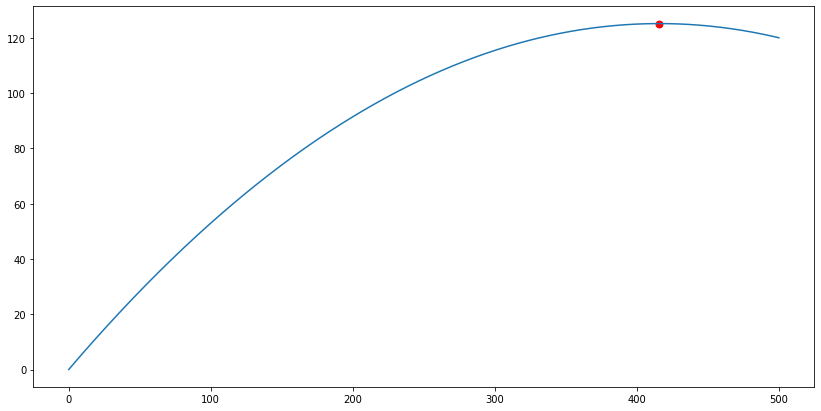

<IPython.core.display.Javascript object>

In [66]:
plt.plot(price_grid, rev_grid)
plt.scatter(p_opt, 0.8 * p_opt * occ_opt, color="red", s=48)

In [28]:
mod_data[["manual Occupancy"]].to_numpy().shape

(47, 1)

<IPython.core.display.Javascript object>

In [29]:
mod_data[["manual Occupancy"]].to_numpy().reshape(-1, 1).shape

(47, 1)

<IPython.core.display.Javascript object>

In [41]:
lr_mod = LinearRegression()
lr_mod.fit(
    X=mod_data["manual Occupancy"].to_numpy().reshape(-1, 1), y=mod_data[["manual ADR"]]
)
lr_mod.coef_

array([[-144.26204633]])

<IPython.core.display.Javascript object>

In [58]:
lr_mod.intercept_[0]

317.76706624451714

<IPython.core.display.Javascript object>

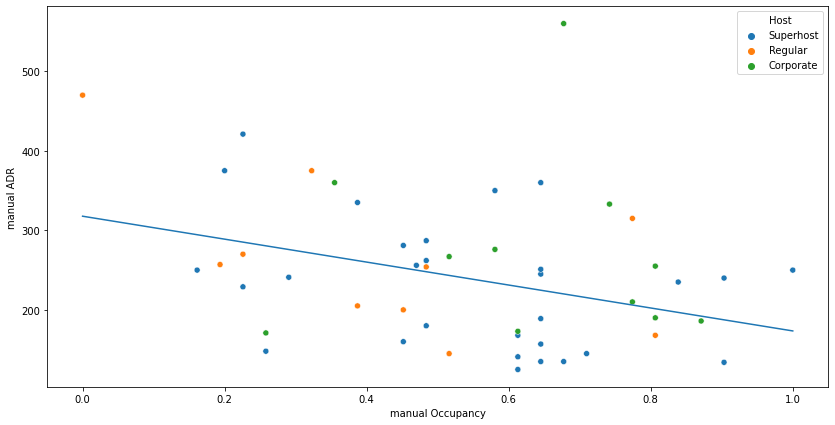

<IPython.core.display.Javascript object>

In [59]:
adr_vs_ocp = sns.scatterplot(
    data=comps, x="manual Occupancy", y="manual ADR", hue="Host"
)

occupancy_grid = np.linspace(0, 1, num=100)
adr_grid = [lr_mod.intercept_[0] + lr_mod.coef_[0] * op for op in occupancy_grid]
plt.plot(occupancy_grid, adr_grid)
plt.show()

In [66]:
adr_grid = np.ndarray.flatten(np.array(adr_grid))

<IPython.core.display.Javascript object>

In [68]:
occupancy_grid * adr_grid

array([  0.        ,   3.19504923,   6.36066023,   9.496833  ,
        12.60356754,  15.68086385,  18.72872193,  21.74714179,
        24.73612341,  27.6956668 ,  30.62577196,  33.52643889,
        36.39766759,  39.23945806,  42.0518103 ,  44.83472431,
        47.58820009,  50.31223764,  53.00683696,  55.67199805,
        58.30772091,  60.91400554,  63.49085194,  66.03826011,
        68.55623005,  71.04476176,  73.50385524,  75.93351049,
        78.33372751,  80.7045063 ,  83.04584686,  85.35774919,
        87.64021329,  89.89323916,  92.1168268 ,  94.31097621,
        96.47568738,  98.61096033, 100.71679505, 102.79319154,
       104.8401498 , 106.85766983, 108.84575163, 110.8043952 ,
       112.73360054, 114.63336765, 116.50369653, 118.34458717,
       120.15603959, 121.93805378, 123.69062974, 125.41376747,
       127.10746697, 128.77172824, 130.40655128, 132.01193608,
       133.58788266, 135.13439101, 136.65146113, 138.13909302,
       139.59728668, 141.0260421 , 142.4253593 , 143.79

<IPython.core.display.Javascript object>

In [20]:


import statsmodels.api as sm

spector_data = sm.datasets.spector.load()

spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(spector_data.endog, spector_data.exog)

res = mod.fit()

print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                  GRADE   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     6.646
Date:                Wed, 12 Jul 2023   Prob (F-statistic):            0.00157
Time:                        21:42:04   Log-Likelihood:                -12.978
No. Observations:                  32   AIC:                             33.96
Df Residuals:                      28   BIC:                             39.82
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GPA            0.4639      0.162      2.864      0.0

<IPython.core.display.Javascript object>

In [24]:
spector_data.endog

0     0.0
1     0.0
2     0.0
3     0.0
4     1.0
5     0.0
6     0.0
7     0.0
8     0.0
9     1.0
10    0.0
11    0.0
12    0.0
13    1.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    1.0
20    0.0
21    1.0
22    0.0
23    0.0
24    1.0
25    1.0
26    1.0
27    0.0
28    1.0
29    1.0
30    0.0
31    1.0
Name: GRADE, dtype: float64

<IPython.core.display.Javascript object>

In [26]:
X

NameError: name 'X' is not defined

<IPython.core.display.Javascript object>

--------------------
## Seasonality

In [122]:
seasonality["seasonal_adj"] = seasonality["Revenue"] / 4866
seasonality["seasonal_revenue"] = (
    p_opt * occ_opt * seasonality["seasonal_adj"] * 365.25 / 12
)

<IPython.core.display.Javascript object>

In [123]:
seasonality

,Month,Revenue,Jan,Jul,seasonal_adj,seasonal_revenue
0,1,2311,1.000000,0.474928,0.474928,2261.879019
1,2,2388,1.033319,0.490752,0.490752,2337.242361
2,3,2312,1.000433,0.475134,0.475134,2262.857763
3,4,2080,0.900043,0.427456,0.427456,2035.788991
4,5,2833,1.225876,0.582203,0.582203,2772.783756
5,6,3901,1.688014,0.801685,0.801685,3818.083103
6,7,4866,2.105582,1.000000,1.000000,4762.571746
7,8,5370,2.323669,1.103576,1.103576,5255.859079
8,9,3403,1.472523,0.699342,0.699342,3330.668239
9,10,2452,1.061013,0.503905,0.503905,2399.882023


<IPython.core.display.Javascript object>

In [127]:
annual_rev = seasonality.seasonal_revenue.sum().round()
annual_rev

36102.0

<IPython.core.display.Javascript object>

In [134]:
((3 / 4) * (2 / 3) * annual_rev) / 400000

0.0451275

<IPython.core.display.Javascript object>